In [1]:
import copy
import numpy as np
from Trip import Trip
from Point import Point
from Trips import Trips
import math
import matplotlib.pyplot as plt
import gurobipy as gb
from Simulation import Simulation
from Solver import Solver


In [32]:
def sm_matheuristic(J,D,trips):
    I=range(len(trips))
    # to construct theta
    # TODO Controllare
    theta=np.zeros((len(trips),len(J)))
    for i in I:
        for j in range(len(J)):
            theta[i,j]=1 if any(obj.u == J[j].u and J[j].v for obj in trips[i].J) else 0

    C=[]
    for trip in trips:
        time_pure_taxi_trip=trip.get_pure_taxi_trip()
        trip_time_drop_off_array=trip.get_array_pure_taxi_trip_drop_off()
        realocation_move_time_array=[]

        for j in trip.J:
            time_plus_realocation=copy.deepcopy(trip_time_drop_off_array)
            for idx, pi_p in enumerate(trip.pi):
                realocation_move_time=Trip.get_travel_time_relocation_move(j,pi_p)
                time_plus_realocation[idx]+=realocation_move_time

            realocation_move_time_array.append(min(time_plus_realocation))
        if realocation_move_time_array != []:
            time_result=max(time_pure_taxi_trip,max(realocation_move_time_array))
        else:
            time_result=max(time_pure_taxi_trip,0)
        C.append(time_result)

    sm_mip = gb.Model()
    sm_mip.modelSense = gb.GRB.MINIMIZE #declare mimization
    Y = sm_mip.addVars( [i for i in I], vtype=gb.GRB.BINARY)
    for j in range(len(J)):
        sm_mip.addConstr( gb.quicksum(Y[i]*theta[i,j] for i in I) >= 1 )

    sm_mip.setObjective(gb.quicksum( Y[i]*C[i]  for i in I))
    sm_mip.optimize()

    # print( "\n", type(Y), Y, "\n")
    # print("\nSolution")
    #
    # for i in I:
    #     if Y[i].x==1:
    #         print(f'Y[{i}]= {Y[i].x}')

    copied_trips = copy.deepcopy(trips)
    new_trips = [copied_trips[idx] for idx in range(len(copied_trips)) if Y[idx].x == 1]

    return new_trips


In [14]:
n,m,ks,kr,kn,T_start,c=Simulation.get_simulation_number(0)

In [15]:
J,D=Simulation.initialize_map(n)

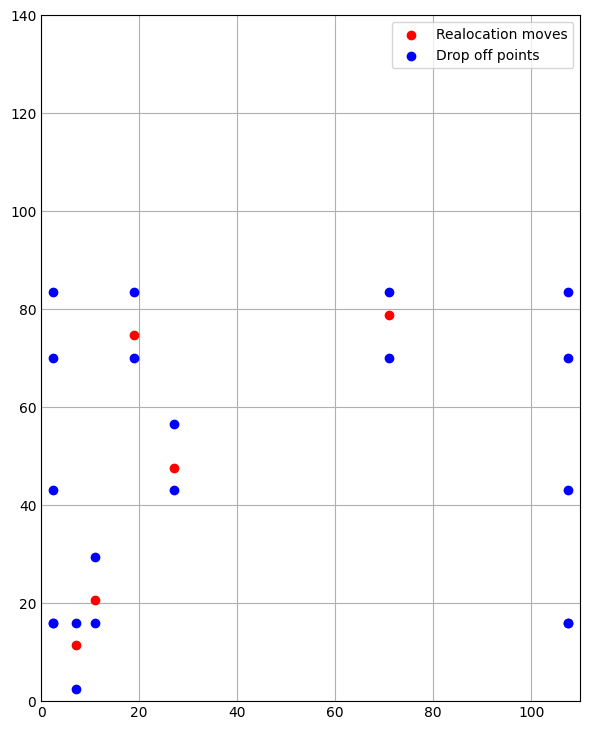

In [16]:
Simulation.plot_map(J,D,[],figsize=(5.5,7))

In [19]:
trips=Solver.sa_approach(n, m, ks, kr, kn, T_start, c, J, D, Point(0,0), Point(0,0))

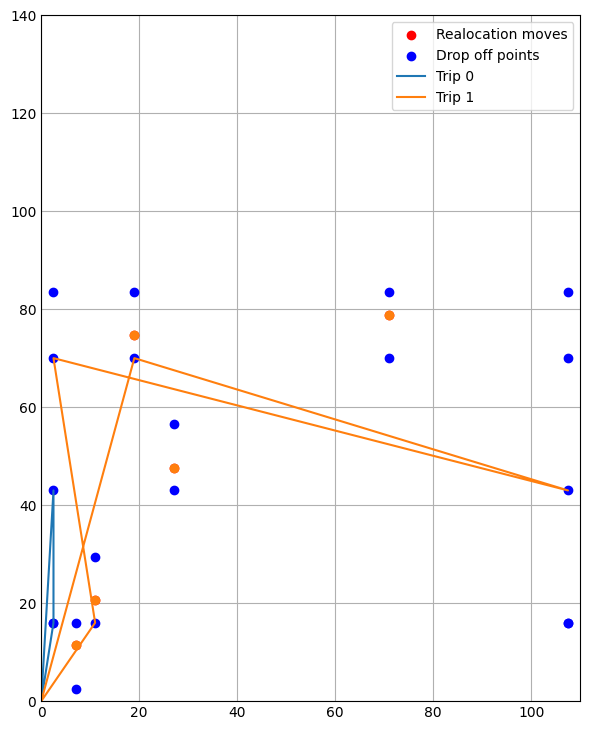

In [29]:
Simulation.plot_map(J,D,trips,figsize=(5.5,7))

In [27]:
print(trips[0])

J: pi: (0,0) (2.5,43.0) (2.5,16.0) (0,0) k=2


In [33]:
new_trips=sm_matheuristic(J,D,trips)


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5 rows, 2 columns and 5 nonzeros
Model fingerprint: 0x169a3dab
Variable types: 0 continuous, 2 integer (2 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 78.3383073
Presolve removed 5 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 78.3383 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.833830733559e+01, best bound 7.833830733559e+01, gap 0.0000%

 <class 'gurobipy.tupledict'> {0: <gurobi.Var C0 (value 0.0)>, 1: <gurobi.Var C1 (value 1.0)>} 


Solution
Y[1]= 1.0


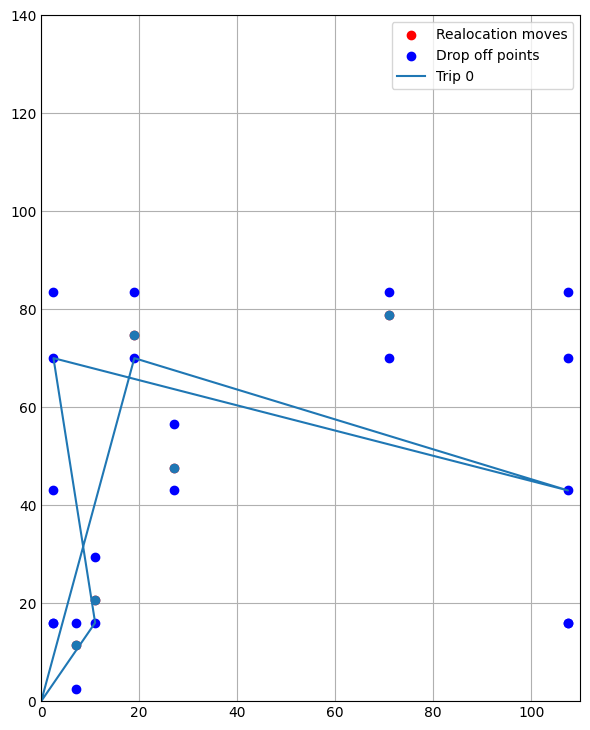

In [34]:
Simulation.plot_map(J,D,new_trips,figsize=(5.5,7))


In [11]:
trips_localsearch=Solver.local_search(new_trips,J,D,100000)


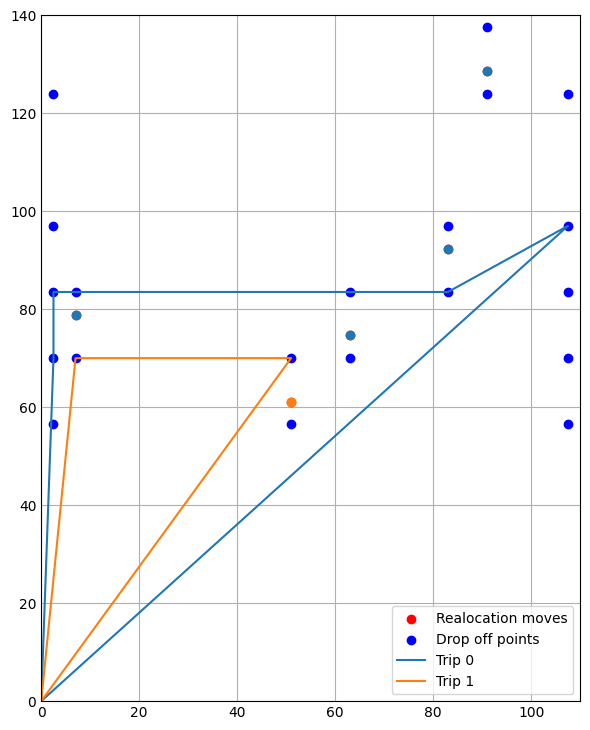

In [13]:
Simulation.plot_map(J,D,trips_localsearch,figsize=(5.5,7))


In [14]:
time_cc=Trips.get_total_duration(trips)
time_sam=Trips.get_total_duration(new_trips)
time_local_search=Trips.get_total_duration(trips_localsearch)
print(f"time cc = {time_cc}")
print(f"time sam = {time_sam}")
print(f"time localsearch = {time_local_search}")


time cc = 105.83333333333334
time sam = 105.83333333333334
time localsearch = 105.59979127370528


In [25]:
max([])


ValueError: max() arg is an empty sequence